In [11]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math

class Validator:
    def __init__(self, deposit, start_dynasty):
        # Used to determine the amount of wei the validator holds. To get the actual
        # amount of wei, multiply this by the deposit_scale_factor.
        self.deposit = deposit
        self.start_dynasty = start_dynasty
        self.end_dynasty = 100000000
        self.is_slashed = False
        self.total_deposits_at_logout = 0
        # The address which the validator's signatures must verify against
        self.addr = None
        self.withdrawal_addr = None


class Checkpoint:
    def __init__(self):
        # track size of scaled deposits for use in client fork choice
        self.cur_dyn_deposits = 0
        self.prev_dyn_deposits = 0
        # track total votes for each dynasty
        self.cur_dyn_votes = {0: 0}
        self.prev_dyn_votes = {0: 0}
        # Is a vote referencing the given epoch justified?
        self.is_justified = False
        # Is a vote referencing the given epoch finalized?
        self.is_finalized = False


class CasperContract:

    def __init__(self):

        # Map of validators and validator index
        self.validators = dict()

        # Next available validator index
        self.next_validator_index = 0

        # Current dynasty, it measures the number of finalized checkpoints
        # in the chain from root to the parent of current block
        self.dynasty = 0

        # Map of the change to total deposits for specific dynasty
        self.dynasty_wei_delta = {0: 0.0}

        # Total scaled deposits in the current dynasty
        self.total_curdyn_deposits = 0

        # Total scaled deposits in the previous dynasty
        self.total_prevdyn_deposits = 0

        # Mapping of dynasty to start epoch of that dynasty
        self.dynasty_start_epoch = {0: 0}

        # Mapping of epoch to what dynasty it is
        self.dynasty_in_epoch = {0: 0}

        self.checkpoints = {0: Checkpoint()}

        # Is the current expected hash justified
        self.main_hash_justified = False

        # Value used to calculate the per-epoch fee that validators should be charged
        self.deposit_scale_factor = {0: 1.0}

        self.last_nonvoter_rescale = 0.0
        self.last_voter_rescale = 0.0

        self.current_epoch = 0
        self.last_finalized_epoch = 0
        self.last_justified_epoch = 0

        # Reward for voting as fraction of deposit size
        self.reward_factor = 0.0

        # Expected source epoch for a vote
        self.expected_source_epoch = 0

        # Running total of deposits slashed
        self.total_slashed = {0: 0.0}

        # ***** Parameters *****

        # Length of an epoch in blocks
        self.EPOCH_LENGTH = 50

        # Withdrawal delay in blocks
        self.WITHDRAWAL_DELAY = 1.5e4

        # Logout delay in dynasties
        self.DYNASTY_LOGOUT_DELAY = 700

        self.BASE_INTEREST_FACTOR = 7e-3
        self.BASE_PENALTY_FACTOR = 2e-7
        self.MIN_DEPOSIT_SIZE = 1.5e21
        self.ETHER_IN_WEI = 1e18
        self.ONE_WEI = 1e-18

        self.DEFAULT_END_DYNASTY = 100000000

        # ****** Pre-defined Constants ******

        self.SLASH_FRACTION_MULTIPLIER = 3

    # Returns number of epochs since finalization.
    def esf(self):
        return self.current_epoch - self.last_finalized_epoch

    # Compute square root factor
    def sqrt_of_total_deposits(self):
        epoch = self.current_epoch
        ether_deposited_as_number = 1 + math.floor(
            max(self.total_prevdyn_deposits, self.total_curdyn_deposits) *
            self.deposit_scale_factor[epoch - 1] /
            self.ETHER_IN_WEI
        )

        sqrt = ether_deposited_as_number / 2.0
        for i in range(20):
            sqrt = (sqrt + (ether_deposited_as_number / sqrt)) / 2.0
        return sqrt

    def deposit_exists(self):
        return self.total_curdyn_deposits > 0.0 and self.total_prevdyn_deposits > 0.0

    def in_dynasty(self, validator_index, _dynasty):
        start_dynasty = self.validators[validator_index].start_dynasty
        end_dynasty = self.validators[validator_index].end_dynasty
        return (start_dynasty <= _dynasty) and (_dynasty < end_dynasty)

    # Increment dynasty when checkpoint is finalized.
    def increment_dynasty(self):
        epoch = self.current_epoch
        # Increment the dynasty if finalized

        if self.dynasty not in self.dynasty_wei_delta:
            self.dynasty_wei_delta[self.dynasty] = 0.0

        if epoch < 2 or self.checkpoints[epoch - 2].is_finalized:
            self.dynasty += 1
            self.total_prevdyn_deposits = self.total_curdyn_deposits

            if self.dynasty - 1 in self.dynasty_wei_delta:
                self.total_curdyn_deposits += self.dynasty_wei_delta[self.dynasty - 1]

            self.dynasty_start_epoch[self.dynasty] = epoch
        self.dynasty_in_epoch[epoch] = self.dynasty
        if self.main_hash_justified:
            self.expected_source_epoch = epoch - 1
        self.main_hash_justified = False

    def insta_finalize(self):
        epoch = self.current_epoch
        self.main_hash_justified = True

        if epoch > 0:
            self.checkpoints[epoch - 1].is_justified = True
            self.checkpoints[epoch - 1].is_finalized = True
            self.last_justified_epoch = epoch - 1
            self.last_finalized_epoch = epoch - 1
        else:
            self.checkpoints[0].is_finalized = True
            self.checkpoints[0].is_justified = True
            self.last_justified_epoch = 0
            self.last_finalized_epoch = 0

    # Returns the current collective reward factor, which rewards the dynasty for high-voting levels.
    def collective_reward(self):
        epoch = self.current_epoch
        live = self.esf() <= 2
        if not self.deposit_exists() or not live:
            return 0.0
        # Fraction that voted
        cur_vote_frac = 0
        if self.expected_source_epoch in self.checkpoints[epoch - 1].cur_dyn_votes:
            cur_vote_frac = self.checkpoints[epoch - 1].cur_dyn_votes[
                                self.expected_source_epoch] / self.total_curdyn_deposits
        prev_vote_frac = 0
        if self.expected_source_epoch in self.checkpoints[epoch - 1].prev_dyn_votes:
            prev_vote_frac = self.checkpoints[epoch - 1].prev_dyn_votes[
                                 self.expected_source_epoch] / self.total_prevdyn_deposits

        vote_frac = min(cur_vote_frac, prev_vote_frac)
        return vote_frac * self.reward_factor / 2.0

    # Reward the given validator & miner, and reflect this in total deposit figured
    def proc_reward(self, validator_index, reward):
        # Reward validator
        self.validators[validator_index].deposit += reward
        start_dynasty = self.validators[validator_index].start_dynasty
        end_dynasty = self.validators[validator_index].end_dynasty
        current_dynasty = self.dynasty
        past_dynasty = current_dynasty - 1
        if (start_dynasty <= current_dynasty) and (current_dynasty < end_dynasty):
            self.total_curdyn_deposits += reward
        if (start_dynasty <= past_dynasty) and (past_dynasty < end_dynasty):
            self.total_prevdyn_deposits += reward
        if end_dynasty < self.DEFAULT_END_DYNASTY:  # validator has submit `logout`
            self.dynasty_wei_delta[end_dynasty] -= reward

    # Removes a validator from the validator pool
    def delete_validator(self, validator_index):
        self.validators[validator_index] = None

    def total_curdyn_deposits_in_wei(self):
        return self.ONE_WEI * math.floor(self.total_curdyn_deposits * self.deposit_scale_factor[self.current_epoch])

    def total_prevdyn_deposits_in_wei(self):
        return self.ONE_WEI * math.floor(self.total_prevdyn_deposits * self.deposit_scale_factor[self.current_epoch])

    def deposit_size(self, validator_index):
        return self.ONE_WEI * math.floor(
            self.validators[validator_index].deposit * self.deposit_scale_factor[self.current_epoch])

    # Called at the start of any epoch
    def initialize_epoch(self, epoch):

        # must track the deposits related to the checkpoint _before_ updating current_epoch
        self.checkpoints[epoch] = Checkpoint()
        self.checkpoints[epoch].cur_dyn_deposits = self.total_curdyn_deposits_in_wei()
        self.checkpoints[epoch].prev_dyn_deposits = self.total_prevdyn_deposits_in_wei()

        self.current_epoch = epoch

        self.last_voter_rescale = 1.0 + self.collective_reward()
        self.last_nonvoter_rescale = self.last_voter_rescale / (1.0 + self.reward_factor)

        if epoch > 0:
            self.deposit_scale_factor[epoch] = self.deposit_scale_factor[epoch - 1] * self.last_nonvoter_rescale
            self.total_slashed[epoch] = self.total_slashed[epoch - 1]

        if self.deposit_exists():
            # Set the reward factor for the next epoch.
            adj_interest_base = self.BASE_INTEREST_FACTOR / self.sqrt_of_total_deposits()
            # self.reward_factor = adj_interest_base
            self.reward_factor = adj_interest_base + self.BASE_PENALTY_FACTOR * (self.esf() - 2)
            # ESF is only thing that is changing and reward_factor is being used above.
            assert self.reward_factor > 0.0
        else:
            # Before the first validator deposits, new epochs are finalized instantly.
            self.insta_finalize()
            self.reward_factor = 0

        # Increment the dynasty if finalized
        self.increment_dynasty()

    def deposit(self, value):
        assert value >= self.MIN_DEPOSIT_SIZE
        validator_index = self.next_validator_index
        start_dynasty = self.dynasty + 2
        scaled_deposit = value / self.deposit_scale_factor[self.current_epoch]
        self.validators[validator_index] = Validator(scaled_deposit, start_dynasty)
        self.next_validator_index += 1

        if start_dynasty not in self.dynasty_wei_delta:
            self.dynasty_wei_delta[start_dynasty] = 0

        self.dynasty_wei_delta[start_dynasty] += scaled_deposit
        return validator_index

    def logout(self, validator_index):

        # Check that we haven't already withdrawn
        end_dynasty = self.dynasty + self.DYNASTY_LOGOUT_DELAY
        assert self.validators[validator_index].end_dynasty > end_dynasty

        self.validators[validator_index].end_dynasty = end_dynasty
        self.validators[validator_index].total_deposits_at_logout = self.total_curdyn_deposits_in_wei()
        self.dynasty_wei_delta[end_dynasty] -= self.validators[validator_index].deposit

    def withdraw(self, validator_index):
        # Check that we can withdraw
        end_dynasty = self.validators[validator_index].end_dynasty
        assert self.dynasty > end_dynasty

        end_epoch = self.dynasty_start_epoch[end_dynasty + 1]
        withdrawal_epoch = end_epoch + self.WITHDRAWAL_DELAY
        assert self.current_epoch >= withdrawal_epoch

        # Withdraw
        if not self.validators[validator_index].is_slashed:
            withdraw_amount = self.ONE_WEI * self.validators[validator_index].deposit * self.deposit_scale_factor[
                end_epoch]
        else:
            # prevent a negative lookup in total_slashed
            if 2 * self.WITHDRAWAL_DELAY > withdrawal_epoch:
                base_epoch = 0
            else:
                base_epoch = withdrawal_epoch - 2 * self.WITHDRAWAL_DELAY

            recently_slashed = self.total_slashed[withdrawal_epoch] - self.total_slashed[base_epoch]
            fraction_to_slash = recently_slashed * self.SLASH_FRACTION_MULTIPLIER / self.validators[
                validator_index].total_deposits_at_logout

            # can't withdraw a negative amount
            fraction_to_withdraw = max((1.0 - fraction_to_slash), 0.0)

            deposit_size = self.ONE_WEI * math.floor(
                self.validators[validator_index].deposit * self.deposit_scale_factor[withdrawal_epoch])

            withdraw_amount = self.ONE_WEI * math.floor(deposit_size * fraction_to_withdraw)

        self.delete_validator(validator_index)
        return withdraw_amount

    # Process a vote message
    def vote(self, validator_index, source_epoch, target_epoch):

        # Record that this vote took place
        in_current_dynasty = self.in_dynasty(validator_index, self.dynasty)
        in_prev_dynasty = self.in_dynasty(validator_index, self.dynasty - 1)

        current_dynasty_votes = 0
        if source_epoch in self.checkpoints[target_epoch].cur_dyn_votes:
            current_dynasty_votes = self.checkpoints[target_epoch].cur_dyn_votes[source_epoch]

        previous_dynasty_votes = 0
        if source_epoch in self.checkpoints[target_epoch].prev_dyn_votes:
            previous_dynasty_votes = self.checkpoints[target_epoch].prev_dyn_votes[source_epoch]

        if in_current_dynasty:
            current_dynasty_votes += self.validators[validator_index].deposit
            self.checkpoints[target_epoch].cur_dyn_votes[source_epoch] = current_dynasty_votes
        if in_prev_dynasty:
            previous_dynasty_votes += self.validators[validator_index].deposit
            self.checkpoints[target_epoch].prev_dyn_votes[source_epoch] = previous_dynasty_votes

        # Process rewards.
        # Pay the reward if the vote was submitted in time and the vote is voting the correct data
        reward = 0
        if self.expected_source_epoch == source_epoch:
            reward = self.validators[validator_index].deposit * self.reward_factor
            self.proc_reward(validator_index, reward)

        # If enough votes with the same source_epoch and hash are made,
        # then the hash value is justified
        two_thirds_curdyn = current_dynasty_votes >= self.total_curdyn_deposits * 2.0 / 3.0
        two_thirds_prevdyn = previous_dynasty_votes >= self.total_prevdyn_deposits * 2.0 / 3.0
        enough_votes = two_thirds_curdyn and two_thirds_prevdyn

        if enough_votes and not self.checkpoints[target_epoch].is_justified:
            self.checkpoints[target_epoch].is_justified = True
            self.last_justified_epoch = target_epoch
            self.main_hash_justified = True

            # If two epochs are justified consecutively,
            # then the source_epoch finalized
            if target_epoch == source_epoch + 1:
                self.checkpoints[source_epoch].is_finalized = True
                self.last_finalized_epoch = source_epoch

        return reward

    # Cannot sign two votes for same target_epoch; no surround vote.
    def slash(self, validator_index):

        validator_deposit = self.deposit_size(validator_index)
        slashing_bounty = validator_deposit / 25
        self.total_slashed[self.current_epoch] += validator_deposit
        self.validators[validator_index].is_slashed = True

        # if validator not logged out yet, remove total from next dynasty
        # and forcibly logout next dynasty
        end_dynasty = self.validators[validator_index].end_dynasty
        if self.dynasty < end_dynasty:
            deposit = self.validators[validator_index].deposit
            self.dynasty_wei_delta[self.dynasty + 1] -= deposit
            self.validators[validator_index].end_dynasty = self.dynasty + 1

            # if validator was already staged for logout at end_dynasty,
            # ensure that we don't doubly remove from total
            if end_dynasty < self.DEFAULT_END_DYNASTY:
                self.dynasty_wei_delta[end_dynasty] += deposit
            # if no previously logged out, remember the total deposits at logout
            else:
                self.validators[validator_index].total_deposits_at_logout = self.total_curdyn_deposits_in_wei()

        return slashing_bounty


# Unit-e validator rewards and economics



## 1.0 Casper economics

This section analyzes the casper economic model.

There are few important functions that define how the validator's deposit evolves overtime and how rewards are distributed and in which amount; here we will try to define and analyze their behavior over time in order to get a better picture of how those important factors variate.

### General definitions

Let's start giving some generic useful definitions used extensively.


#### Epoch
Is a group of $\sigma$ subsequent blocks where $\sigma \in \mathbb{N}$ is called "epoch size".

Given the epoch size $\sigma$, and the set of all the existing blocks $\{b_{genesis}, b_1, ..., b_i\}$ we define the _n-th_ epoch as $ e_{n,\sigma}=\{b_{n\sigma}, b_{n\sigma+1}, ..., b_{n\sigma+\sigma-1}\} $.

the epoch size $\sigma$ is a static parameter initialized and never changed after the final definition of the protocol. For simplicity it will not be part of further difinitions.


#### Dynasty
A dynasty is a set of epochs that have been finalized together. This represents the dynasty of validators that is active for such epochs.  

If we define the set of all epochs $E=\{e_0, ..., e_n\}$ and the set of all dynasties $D=\{d_0, ..., d_n\}$ then we can define the _dynasty function_ $d:E\rightarrow D$ that maps any _epoch_ to its _dynasty_.

In optimal scenarios, where finalization happens every epoch, the function will constatly be in the form of $d(e_n)=d_n$.

#### Initial parameters
Casper's initial parameters are configured to achieve specific returns under specific conditions[1].
- 200k ETH minimum deposits
- ~4 months withdraw delay
- logout delay at 700 dynasties
- Base Interest Factor at $7\cdot10^{-3}$ to achieve a 5% return with ~$10^{7}$ ETH in deposits.
- Base Penalty Factor at $2\cdot10^{-7}$ so that if 50% of validator are offline then after ~3 weeks, the remaining pool will form a new majority.
- the minimum deposit is 1500 ETH creating ~900 validators considering ~$10^{7}$ ETH in deposits.

### Deposit scale factor
This function is used to scale the deposited amount of the validator when he enters the validator set, and then to scale any dimension related to deposits up till the witdrawable amount at the moment of attempting a withdraw.

We introduce here the _deposit scale factor function_ defined in the following way:

$$
\begin{equation*}
    d_{sf}(t) =
        \begin{cases}
          1                                      & t = 0 \\
          d_{sf}(t-1) \frac{1+c_r(t)}{1+r_f(t)}  & \text{otherwise} \\
        \end{cases}
\end{equation*}
$$

where $r_f(t)$ is the _reward factor_ and $c_r(t)$ is the _collective reward.

At the epoch $t$, given $d_v(d)$ the dynasty _votes_ $d$ and $d_{td}(d)$ the dynasty _total deposits_ $d$  then we can define $c_r(t)$ the _collective reward function_ as:

$$ c_r(t)=min\Big(\frac{d_v(d(t-1))}{d_{td}(d(t))}, \frac{d_v(d(t-1)-1)}{d_{td}(d(t)-1)}\Big) \frac{r_f(t)}{2}$$

given the _reward factor_ $r_f(t)$ defined as:

$$
r_f(t)=\frac{7\cdot10^{-3}}{\sqrt{{\frac{1 + max\big(d_{td}(d(t)),d_{td}(d(t-1))\big) d_{sf}(t-1)}{10^{18}}}}}+2\cdot10^{-7}e_{sf}(t)=\frac{7\cdot10^{-12}}{\sqrt{1 + max\big(d_{td}(d(t)),d_{td}(d(t-1))\big) d_{sf}(t-1)}}+2\cdot10^{-7}e_{sf}(t)
$$


Specifically $7\cdot10^{-3}$ is the _base interest factor_ and $2\cdot10^{-7}$ is the _base penalty factor_, those are a protocol initial parameters. $10^{18}$ represents a scaling factor equivalent to the amount of _wei_s per _ether_. The function $e_{sf}(t)$ measures the distance in epocs between the epoch $t$ and the last finalized epoch.


We now assume that finalization will be accomplished every epoch and the deposits will not vary in time. In this scenario if we set the total constant deposits in the system to $10^{7}$ ETH (casper's ideal scenario) we can observe the bahvior of $d_{sf}(t)$ as it linearly decreases with a loss of ~5%/yr:

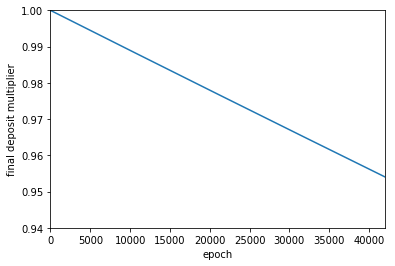

In [16]:
BASE_INTEREST_FACTOR = 7e-3
time_span = int(1 * (365 * 24 * 3600 / (15 * 50)))  # 1 year of epochs
deposits = 10e24
dsf = [1.0]

def reward_factor(dyn):
    global deposits
    sqrt_dep = math.sqrt(1 + (deposits * dsf[dyn] / 1e18))
    return BASE_INTEREST_FACTOR / sqrt_dep

def collective_reward(dyn):
    return reward_factor(dyn) / 2.0

def deposit_scale_factor(dyn):
    new_dsf = dsf[dyn] * (1 + collective_reward(dyn)) / (1 + reward_factor(dyn))
    dsf.append(new_dsf)
    return new_dsf
    
for i in range(0, time_span):
    deposit_scale_factor(i)
    
plt.plot(range(len(dsf)), dsf)
plt.xlabel('epoch')
plt.ylabel('final deposit multiplier')
plt.axis([0, len(dsf), 0.94, 1.0])
plt.show()

### Vote reward

In the previous paragraph we've shown that a validator would actually lose ETH over time just for being part of the system even in perfect conditions; to avoid this casper introduces a reward for succesful votes.

Every time a validator successfully gets a vote included in a block he will receive a reward equal to its current deposit multiplied by $r_f$.
This reward will compound with the deposit eventually making up for the loss and actually granting a positive ROI.
Given the current validator deposit $v_d(t)$ then we define the vote reward $v_r(t)$ as:

$$
v_r(t)=v_d(t)\cdot r_f(t)
$$

We then include this reward in the previous model and observe that the validators' return over time is linearly increasing in optimal finalization scenarios at a rate of ~5%/yr respective of their deposit.

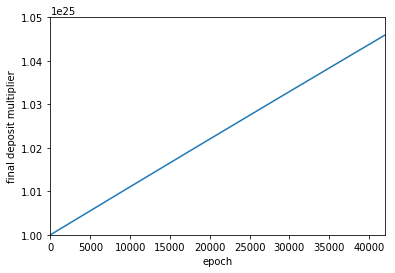

In [25]:
tot_deposits = [10e24]
deposits = tot_deposits[0]

def process_epoch(epoch):
    global deposits
    deposits *= (1 + reward_factor(epoch))
    tot_deposits.append(deposits*dsf[epoch])
 
for i in range(0, time_span):
    process_epoch(i)
    
plt.plot(range(len(tot_deposits)), tot_deposits)
plt.xlabel('epoch')
plt.ylabel('final deposit multiplier')
plt.axis([0, len(tot_deposits), 1.0e25, 1.05e25])
plt.show()

In optimal finalization scenarios the expected return of investment is function of the total amount of deposits in the system. If we consider deposits to remain constant after a certain time $T$ we can describe the expected deposit multiplier as:

$$
v_d(t)= v_d(t-1)\cdot\big(d_{sf}(t) + r_f(t)\big)
$$

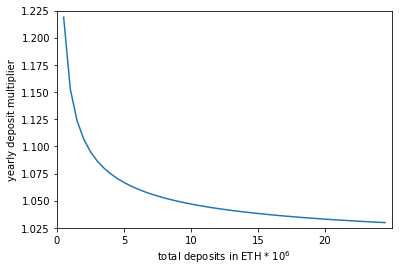

In [30]:
def generate_roi(time_span, deposit):
    c = CasperContract()

    c.initialize_epoch(0)
    c.deposit(deposit)
    roi = []

    for i in range(1, time_span):
        c.initialize_epoch(i)
        c.vote(0, i - 1, i)
        roi.append(c.deposit_size(0) / deposit * 1e18)

    return roi

time_span = int(1 * (365 * 24 * 3600 / (15 * 50)))  # 1 year of epochs

d = list()
for deposit in range(1, 50, 1):
    roi = generate_roi(time_span, deposit * 0.5e24)
    d.append(roi[len(roi)-1])

plt.plot([x * 0.5 for x in range(1, len(d)+1)], d)
plt.xticks(np.arange(0, len(d)*0.5, 5))
plt.xlabel('total deposits in ETH * $10^6$')
plt.ylabel('yearly deposit multiplier')
plt.axis([0, 25, 1.025, 1.225])
plt.show()

### Suboptimal finalization
In case more than a third of the validators will go offline (and stay so) the _base penalty factor_ will kick in causing the rapid shrinking of non-voting validators (how fast depends on how much stake is not voting) and eventually this will lead to a new super-majority of voters being formed so that finalization can continue.

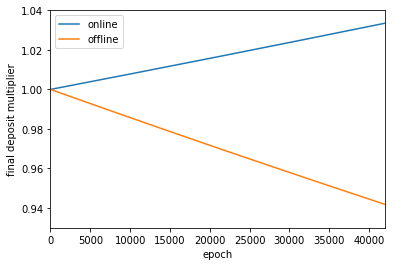

In [28]:
c = CasperContract()

c.initialize_epoch(0)
c.deposit(7e24)
c.deposit(3e24)

roi_online = []
roi_offline = []

for i in range(1, time_span):
    c.initialize_epoch(i)
    c.vote(0, i - 1, i)
    roi_online.append(c.deposit_size(0) / 7e24 * 1e18)
    roi_offline.append(c.deposit_size(1) / 3e24 * 1e18)
    
plt.plot(range(len(roi_online)), roi_online, label="online")
plt.plot(range(len(roi_offline)), roi_offline, label="offline")
plt.xlabel('epoch')
plt.ylabel('final deposit multiplier')
plt.legend(loc='upper left')
plt.axis([0, len(roi_online), 0.93, 1.04])
plt.show()

In case instead that validators are not relyable in voting on time or correctly we are going to witness a slight lower reward rate for the whole network and a decreasing their reward whener they are unable to vote more than ~%60 of the time.

## 2.0 Unit-e token inflation
In this section we ananlyze the model given for the Unit-e token inflation a we try to put in prospective with the economic model given from the casper model and for other PoS coins.

The total supply of Unit-e is the matematical constant $e$, that is defined by the infinite series:

$$
e = \frac{1}{2}\sum_{k=0}^{\infty}\frac{k+1}{k!}
$$

As per [2] we decided to have a high initial token supply in order to prevent strong inequitabilty especially caused by coumpounding effects in early joiners.

## 3.0 Unit-e validators economic model
In this section we do a cost-benefit analysis of running a validator node in order to define a sustainable reward model given the already discussed Unit-e inflation policy and total supply.

### Griefing factor

In case a portion of validators which control the stake percentage $S$ decide not to vote the damage $D$ done to the others is equal to (expressed as a precentage decrease in the reward) considering that it does not prevent finalizion:

$$D = \frac{2 + S \cdot r_f(t)}{2+r_f(t)} 
\text{(can we further simplify?)}
$$


In [93]:
import math

class casper:

    def __init__(self, deposit_distribution, votes_distribution, bif=7e-3):
        self.BASE_INTEREST_FACTOR = bif
        self.deposit_distribution = deposit_distribution
        self.votes_distribution = votes_distribution
        # Save intermidiate values to avoid recursion
        self.dsf = dict()

    # total amount of votes in each dynasty
    def dyn_votes(self, dyn):
        return int(self.total_dyn_deposits(dyn)*self.votes_distribution(dyn))

    # total amount of deposits in each dynasty
    def total_dyn_deposits(self, dyn):
        return self.deposit_distribution(dyn)

    def sqrt_of_total_deposits(self, dyn):
        return math.sqrt(1 + max(self.total_dyn_deposits(dyn), self.total_dyn_deposits(dyn-1)) * self.dsf[dyn-1] / 10e18)

    def reward_factor(self, dyn):
        return self.BASE_INTEREST_FACTOR / self.sqrt_of_total_deposits(dyn)

    def collective_reward(self, dyn):
        cur_vote_frac = self.dyn_votes(dyn) / self.total_dyn_deposits(dyn)
        prev_vote_frac = self.dyn_votes(dyn-1) / self.total_dyn_deposits(dyn-1)
        vote_frac = min(cur_vote_frac, prev_vote_frac)
        return vote_frac * self.reward_factor(dyn) / 2.0

    def deposit_scale_factor(self, dyn):
        if dyn == 0:
           self.dsf[dyn] = 1.0
           return 1

        if dyn-1 not in self.dsf:
            return self.deposit_scale_factor(dyn-1)

        new_dsf = self.dsf[dyn-1] * (1 + self.collective_reward(dyn)) / (1 + self.reward_factor(dyn))
        self.dsf[dyn] = new_dsf
        return new_dsf


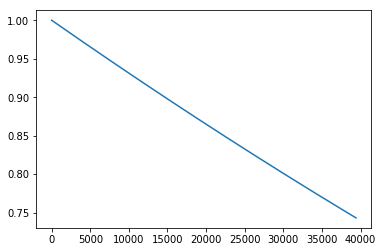

In [94]:
import matplotlib.pyplot as plt
import numpy as np

time_span = int(1 * (365*24*3600/(16*50)))  # 1 year of epochs

deposits = lambda: epoch -> { if epoch == 3: return 10e24}
c1 = casper(lambda dyn: deposits, lambda dyn: 0)
d1 = np.fromfunction(np.vectorize(lambda x: c1.deposit_scale_factor(x), otypes=[np.double]), (time_span,), dtype=np.double)
plt.plot(range(len(d1)), d1)
plt.show()